### Plots for RWKV preprint

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from pathlib import Path
from typing import Union

In [2]:
BASE_PATH = Path("data/")

In [3]:
def groupby_first_n(df: pd.DataFrame, args: Union[str, list[str]] , n: int = None): #  -> pd.GroupBy: 
    """ Keeps up to the first N in a groupby. If n=None, keeps largest possible. """
    new_df = []
    for els, dfs in df.groupby(args): 
        new_df.append(dfs[:n].sort_values("token_id"))
    return pd.concat(new_df).groupby(args)

### Time Plot

In [18]:
df = pd.read_csv(BASE_PATH / "inference_results_hf_cuda.csv")
df_cpu = pd.read_csv(BASE_PATH / "inference_results_hf.csv")
df_cpu = df_cpu[df_cpu.strategy.str.contains("cpu")]
df_rwkv = pd.read_csv(BASE_PATH / "inference_results_rwkv_cuda.csv")
df_rwkv_cpu = pd.read_csv(BASE_PATH / "inference_results_rwkv.csv")
df_rwkv_cpu = df_rwkv_cpu[df_rwkv_cpu.strategy.str.contains("cpu")]

In [19]:
df = pd.concat([df, df_cpu])
df_rwkv = pd.concat([df_rwkv, df_rwkv_cpu])

In [20]:
max_toks = 1024
df_ = groupby_first_n(df, ["model_name", "strategy"], n=max_toks)[["cpu_time"]].sum()
df_rwkv_ = groupby_first_n(df_rwkv, ["model_name", "strategy"], n=max_toks)[["cpu_time"]].sum()
main_df = pd.concat([df_, df_rwkv_]).reset_index()

In [21]:
scale = {"B": 10**9, "m": 10**6, "b": 10**9}
main_df["model_name"] = main_df["model_name"].str.replace("b5", "b").str.replace("b7", "b")
main_df["class"] = main_df["model_name"].apply(lambda x: '-'.join(x.split("/")[1].split("-")[:-1]))
main_df["size"] = main_df["model_name"].apply(lambda x: float(x.split("-")[-1][:-1]) * scale[x.split("-")[-1][-1]])
main_df["strategy"] = main_df["strategy"].apply(lambda x: "cuda" if "cuda" in x else "cpu")
main_df = main_df.sort_values(["size", "strategy"])

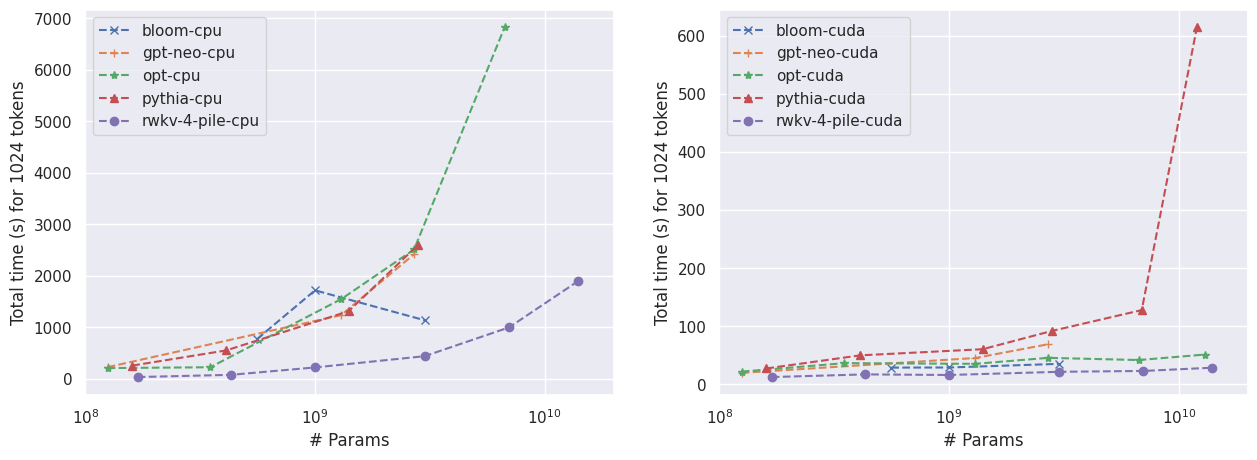

In [22]:
colors = ["r", "b", "g", "y", "k"]
icons = "x+*^o"
alpha = {"cpu": 0.5, "cuda": 1.0}

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i, (class_, model_df) in enumerate(main_df.groupby("class")): 
    for s, strategy in enumerate(["cpu", "cuda"]):
        mask = model_df["strategy"] == strategy
        # axs[s].plot(model_df[mask]["size"], model_df[mask]["cpu_time"]*10**(-6), f'{colors[i]}{icons[i]}--', label=f"{class_}-{strategy}")
        axs[s].plot(model_df[mask]["size"], model_df[mask]["cpu_time"]*10**(-6), f'{icons[i]}--', label=f"{class_}-{strategy}")

for s in [0, 1]: 
    axs[s].legend()
    axs[s].set_xscale("log")
    # axs[s].set_yscale("log")
    axs[s].set_xlabel("# Params")
    axs[s].set_ylabel(f"Total time (s) for {max_toks} tokens")
    axs[s].set_xlim(10**8, 2.*10**10)
    
plt.savefig("total_inference_time.pdf", format="pdf")

### VRAM plot

In [35]:
df = pd.read_csv(BASE_PATH / "inference_results_hf_cuda.csv")
df_cpu = pd.read_csv(BASE_PATH / "inference_results_hf.csv")
df_cpu = df_cpu[df_cpu.strategy.str.contains("cpu")]
df_rwkv = pd.read_csv(BASE_PATH / "inference_results_rwkv_cuda.csv")
df_rwkv_cpu = pd.read_csv(BASE_PATH / "inference_results_rwkv.csv")
df_rwkv_cpu = df_rwkv_cpu[df_rwkv_cpu.strategy.str.contains("cpu")]

In [36]:
df["memory"] = df["self_cuda_memory_usage"].abs()
df_cpu["memory"] = df_cpu["cpu_memory_usage"]
df_rwkv["memory"] = df_rwkv["self_cuda_memory_usage"].abs()
df_rwkv_cpu["memory"] = df_rwkv_cpu["cpu_memory_usage"]

In [37]:
df_rwkv

,Unnamed: 0,model_name,model_size,token_id,final_text,strategy,cpu_time,cuda_time,cpu_memory_usage,cuda_memory_usage,self_cpu_memory_usage,self_cuda_memory_usage,memory
0,0,BlinkDL/rwkv-4-pile-169m,0,0,"\nIn a shocking finding, scientist discovered ...",cuda fp32,2937859.0,15235.0,0,12509696,-125968,-3373568,3373568
1,1,BlinkDL/rwkv-4-pile-169m,0,1,"\nIn a shocking finding, scientist discovered ...",cuda fp32,1151108.0,1912.0,0,-2949120,0,-3414528,3414528
2,2,BlinkDL/rwkv-4-pile-169m,0,2,"\nIn a shocking finding, scientist discovered ...",cuda fp32,7565.0,1491.0,0,0,0,-468992,468992
3,3,BlinkDL/rwkv-4-pile-169m,0,3,"\nIn a shocking finding, scientist discovered ...",cuda fp32,7883.0,1502.0,0,0,0,-468480,468480
4,4,BlinkDL/rwkv-4-pile-169m,0,4,"\nIn a shocking finding, scientist discovered ...",cuda fp32,7827.0,1673.0,0,0,0,-465920,465920
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6139,6139,BlinkDL/rwkv-4-pile-14b,0,1019,"\nIn a shocking finding, scientist discovered ...",cuda fp32,26810.0,37207.0,0,0,0,-6059008,6059008
6140,6140,BlinkDL/rwkv-4-pile-14b,0,1020,"\nIn a shocking finding, scientist discovered ...",cuda fp32,26876.0,37077.0,0,0,0,-6038016,6038016
6141,6141,BlinkDL/rwkv-4-pile-14b,0,1021,"\nIn a shocking finding, scientist discovered ...",cuda fp32,27028.0,37124.0,0,0,0,-6099456,6099456
6142,6142,BlinkDL/rwkv-4-pile-14b,0,1022,"\nIn a shocking finding, scientist discovered ...",cuda fp32,27033.0,37056.0,0,0,0,-5976576,5976576


In [30]:
df = pd.concat([df, df_cpu])
df_rwkv = pd.concat([df_rwkv, df_rwkv_cpu])

In [31]:
# df["memory"] = np.maximum(df["cpu_memory_usage"].values, df["cuda_memory_usage"].values)
# df_rwkv["memory"] = np.maximum(df_rwkv["cpu_memory_usage"].values, df_rwkv["cuda_memory_usage"].values)

max_toks = 1024
df_ = groupby_first_n(df, ["model_name", "strategy"], n=max_toks)[["memory"]].last()
df_rwkv_ = groupby_first_n(df_rwkv, ["model_name", "strategy"], n=max_toks)[["memory"]].sum()
main_df = pd.concat([df_, df_rwkv_]).reset_index()

In [32]:
scale = {"B": 10**9, "m": 10**6, "b": 10**9}
main_df["model_name"] = main_df["model_name"].str.replace("b5", "b").str.replace("b7", "b")
main_df["class"] = main_df["model_name"].apply(lambda x: '-'.join(x.split("/")[1].split("-")[:-1]))
main_df["size"] = main_df["model_name"].apply(lambda x: float(x.split("-")[-1][:-1]) * scale[x.split("-")[-1][-1]])
main_df["strategy"] = main_df["strategy"].apply(lambda x: "cuda" if "cuda" in x else "cpu")
main_df = main_df.sort_values(["size", "strategy"])

In [34]:
main_df

,model_name,strategy,memory,class,size
2,EleutherAI/gpt-neo-125m,cpu,2464724,gpt-neo,1.250000e+08
24,facebook/opt-125m,cpu,3102416,opt,1.250000e+08
3,EleutherAI/gpt-neo-125m,cuda,4092275200,gpt-neo,1.250000e+08
25,facebook/opt-125m,cuda,3869515776,opt,1.250000e+08
9,EleutherAI/pythia-160m,cpu,2060936,pythia,1.600000e+08
10,EleutherAI/pythia-160m,cuda,3755832320,pythia,1.600000e+08
35,BlinkDL/rwkv-4-pile-169m,cpu,385428,rwkv-4-pile,1.690000e+08
36,BlinkDL/rwkv-4-pile-169m,cuda,485514752,rwkv-4-pile,1.690000e+08
29,facebook/opt-350m,cpu,5582600,opt,3.500000e+08
30,facebook/opt-350m,cuda,9735266816,opt,3.500000e+08


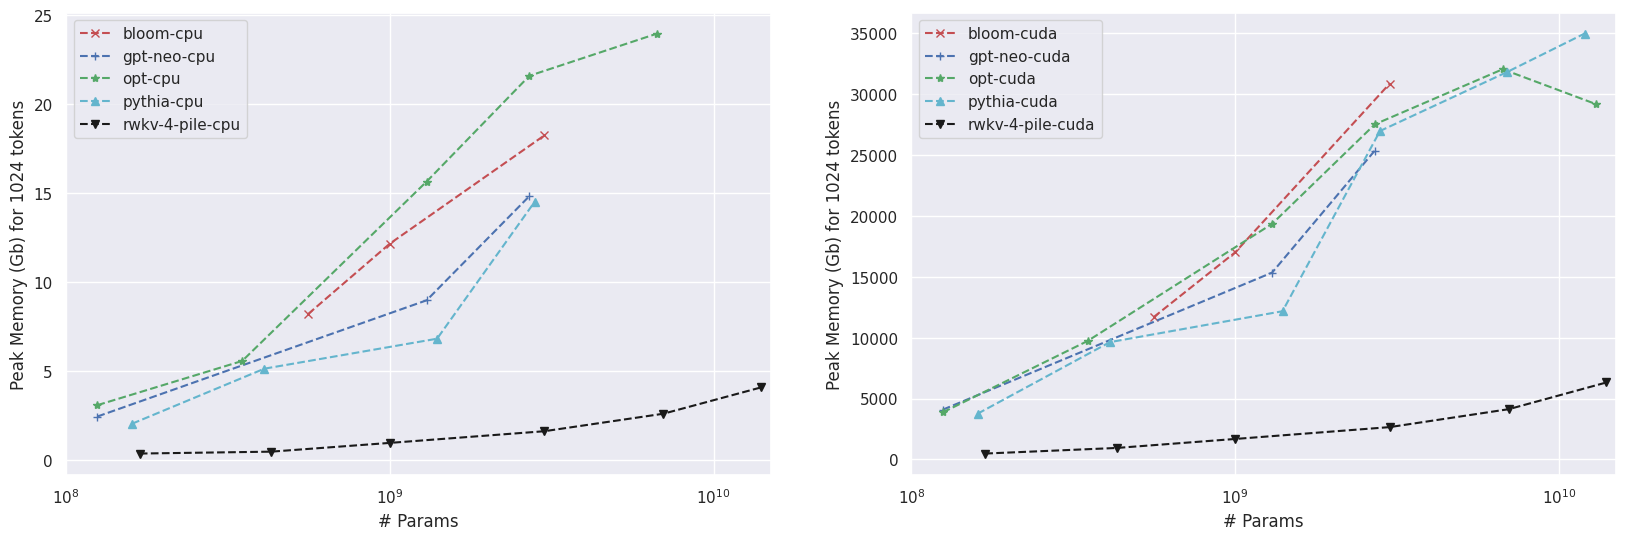

In [33]:
colors = "rbgck"
icons = "x+*^v"
alpha = {"cpu": 0.5, "cuda": 1.0}

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

for i, (class_, model_df) in enumerate(main_df.groupby("class")): 
    for s, strategy in enumerate(["cpu", "cuda"]):
        mask = model_df["strategy"] == strategy
        axs[s].plot(model_df[mask]["size"], model_df[mask]["memory"]*10**(-6), f'{colors[i]}{icons[i]}--', label=f"{class_}-{strategy}") # , alpha=alpha[strategy])

for s in [0, 1]: 
    axs[s].legend()
    axs[s].set_xscale("log")
    # axs[s].set_yscale("log")
    axs[s].set_xlabel("# Params")
    axs[s].set_ylabel(f"Peak Memory (Gb) for {max_toks} tokens")
    axs[s].set_xlim(10**8, 1.5*10**10)

plt.savefig("total_inference_memory.pdf", format="pdf")


In [15]:
rwkv_model_memory = df_rwkv[(df_rwkv["model_name"].str.contains('rwkv')) & (df_rwkv["strategy"].str.contains('cuda'))]
rwkv_model_memory['self_cuda_memory_usage'] = rwkv_model_memory['self_cuda_memory_usage'].abs()

/tmp/ipykernel_372/2820822441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rwkv_model_memory['self_cuda_memory_usage'] = rwkv_model_memory['self_cuda_memory_usage'].abs()


model_name
BlinkDL/rwkv-4-pile-14b     Axes(0.125,0.11;0.775x0.77)
BlinkDL/rwkv-4-pile-169m    Axes(0.125,0.11;0.775x0.77)
BlinkDL/rwkv-4-pile-1b5     Axes(0.125,0.11;0.775x0.77)
BlinkDL/rwkv-4-pile-3b      Axes(0.125,0.11;0.775x0.77)
BlinkDL/rwkv-4-pile-430m    Axes(0.125,0.11;0.775x0.77)
BlinkDL/rwkv-4-pile-7b      Axes(0.125,0.11;0.775x0.77)
Name: self_cuda_memory_usage, dtype: object

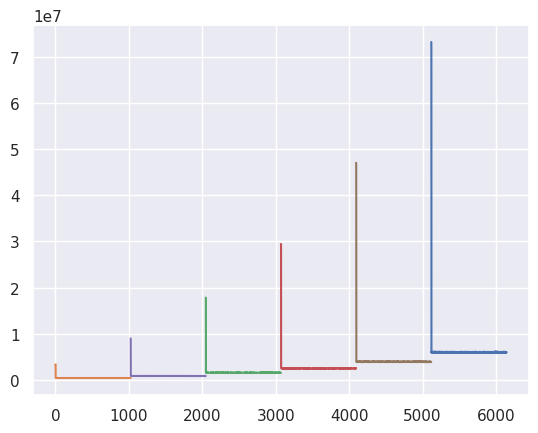

In [16]:
rwkv_model_memory.groupby('model_name')['self_cuda_memory_usage'].plot()